# Generic N-D sweeps

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from lightlab.util.sweep import NdSweeper

In [2]:
# Turn this on when executing interactively
livePlots = False

In [3]:
class Plant():
    def __init__(self):
        self.x = 2
        self.y = 2
        
    def actuateX(self, newX, rounded=False):
        self.x = round(newX) if rounded else newX
        
    def actuateY(self, newY):
        self.y = newY
        
    def measure(self):
        return (np.sin(self.x * self.y/3), self.y / self.x)

## Simplest case

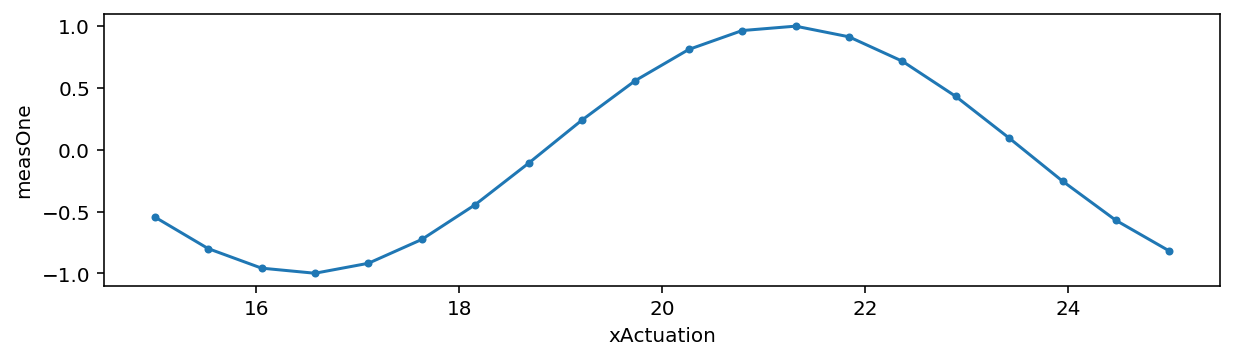

In [4]:
p = Plant()

swpInX = NdSweeper()
swpInX.addActuation('xActuation', lambda x: p.actuateX(x), np.linspace(15, 25, 20))
swpInX.addMeasurement('measOne', lambda: p.measure()[0])
swpInX.setMonitorOptions(stdoutPrint=False, livePlot=livePlots)

swpInX.gather()
if not livePlots:
    swpInX.plot()

## Multiple measurements and a domain parser

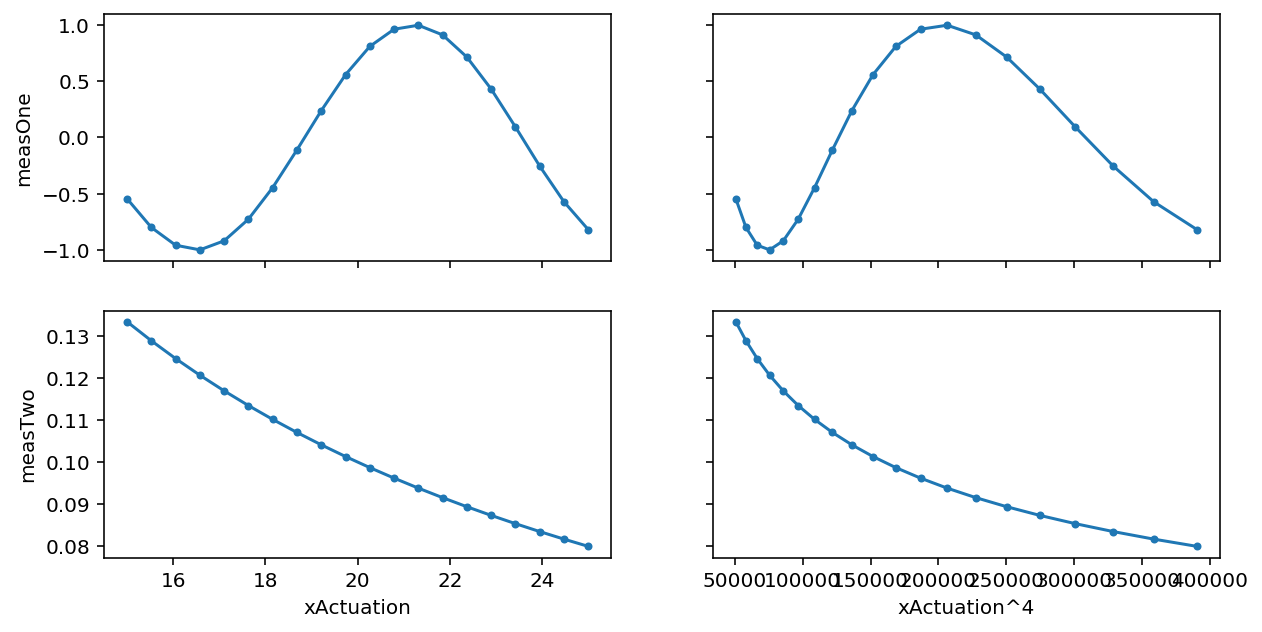

In [5]:
swpInX.addMeasurement('measTwo', lambda: p.measure()[1])
swpInX.addParser('xActuation^4', lambda d: d['xActuation']**4)
swpInX.setPlotOptions(xKey=('xActuation', 'xActuation^4'))
swpInX.gather()
if not livePlots:
    swpInX.plot()

### Adding new parsers after the data has been gathered

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11cd4acd0>]],
      dtype=object)

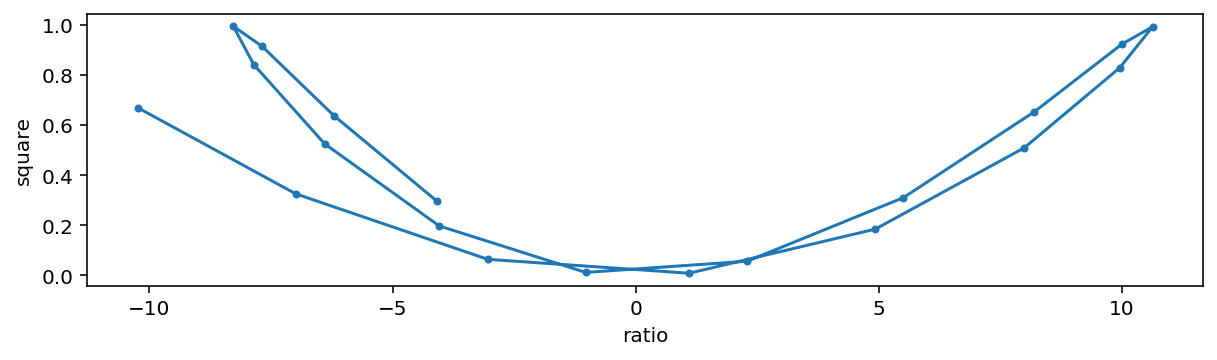

In [6]:
swpInX.addParser('ratio', lambda d: d['measOne'] / d['measTwo'])
swpInX.addParser('square', lambda d: d['measOne'] * d['measOne'])
swpInX.setPlotOptions(xKey='ratio', yKey='square')
swpInX.plot()

## Subsuming to 2D and progress server

In [7]:
# Turn to True if you have your monitor server running (see docs)
runServer = False

swpInY = NdSweeper()
swpInY.addActuation('yActuation', p.actuateY, np.linspace(1, 2, 15))

fullSwp = swpInX.subsume(swpInY)

fullSwp.addParser('norm', lambda x: (x['measOne'] + x['xActuation'])**2)
fullSwp.setMonitorOptions(runServer=runServer, livePlot=livePlots, plotEvery=10, stdoutPrint=False)
fullSwp.setPlotOptions(xKey=('yActuation'), yKey=('norm', 'ratio'))
fullSwp.gather()

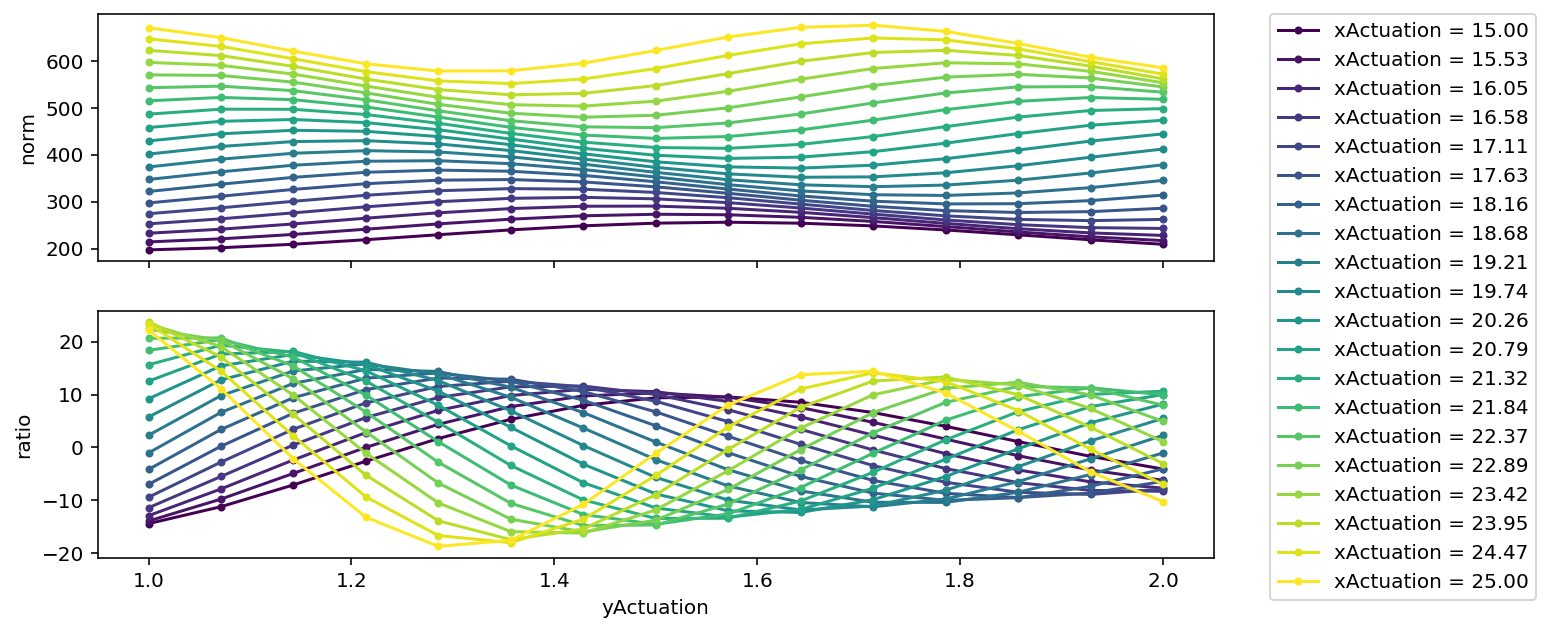

In [8]:
# Default 2D curve plot
fullSwp.setPlotOptions(plType='curves')
_ = fullSwp.plot()

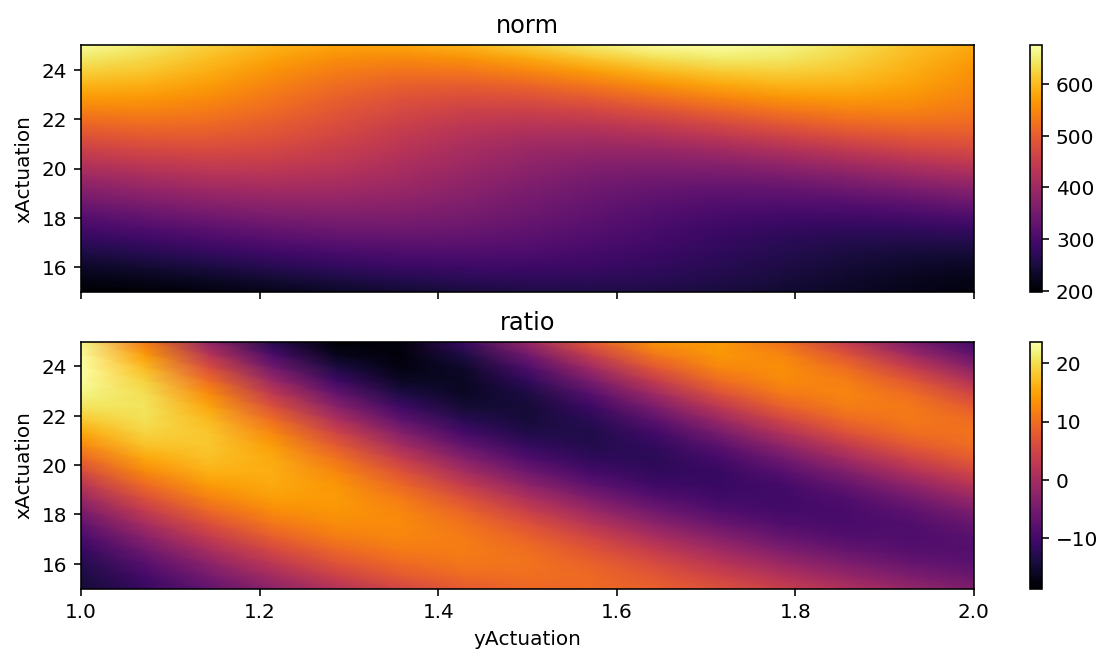

In [9]:
# Surface plot
fullSwp.setPlotOptions(plType='surf')
_ = fullSwp.plot()

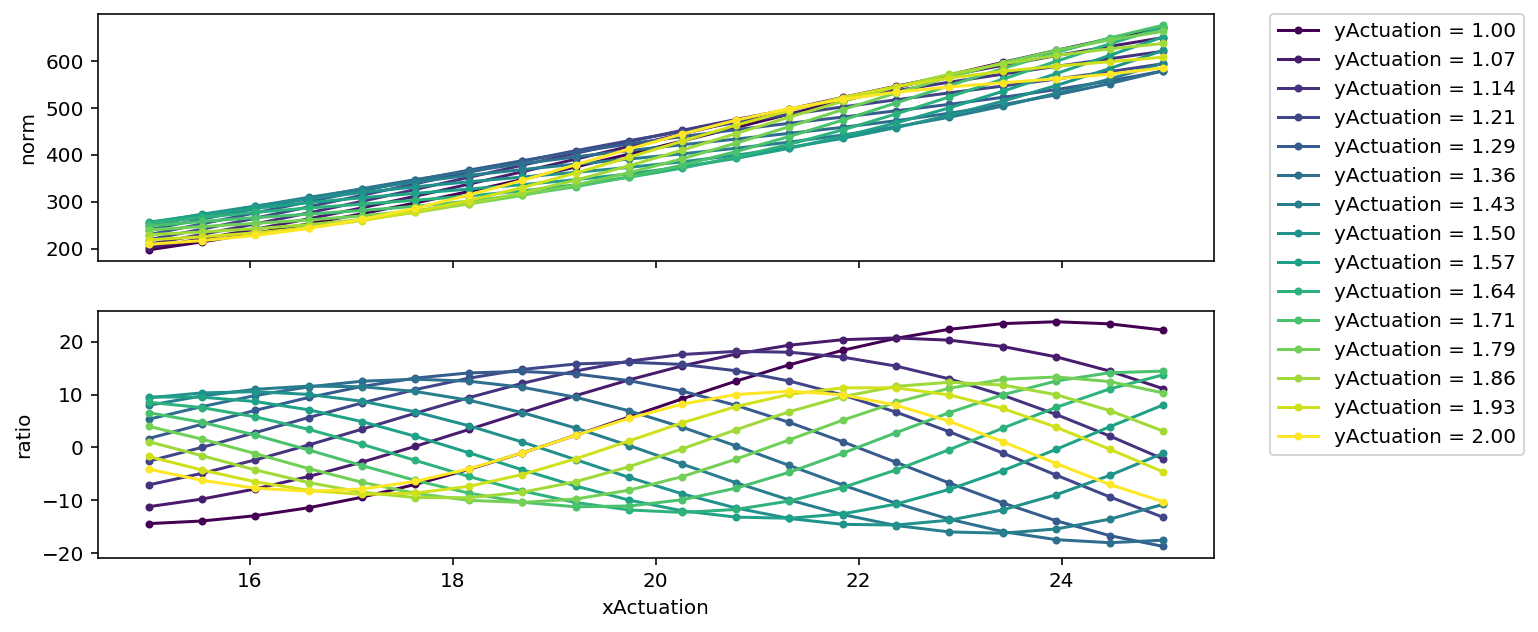

In [10]:
# curves, but with domains reversed. This can reveal other things
fullSwp.setPlotOptions(plType='curves', xKey='xActuation')
_ = fullSwp.plot()

## Using static data to compare subsequent sweeps

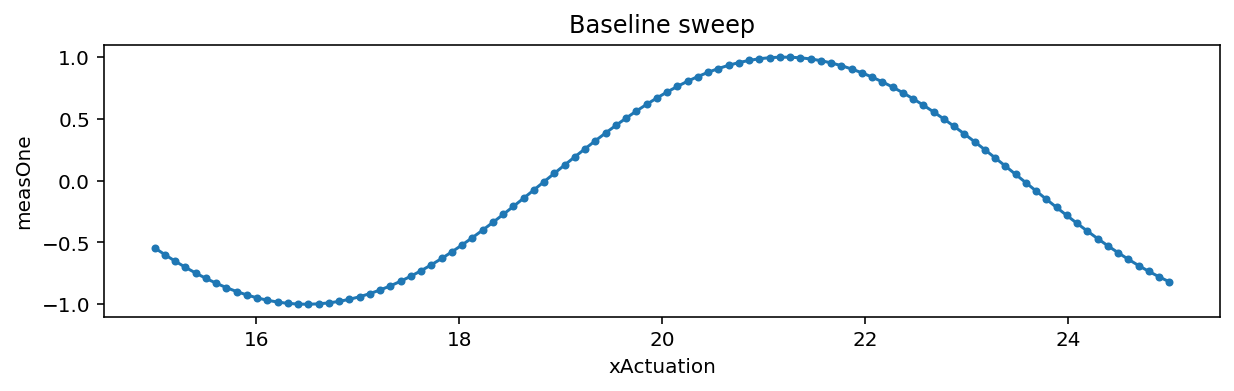

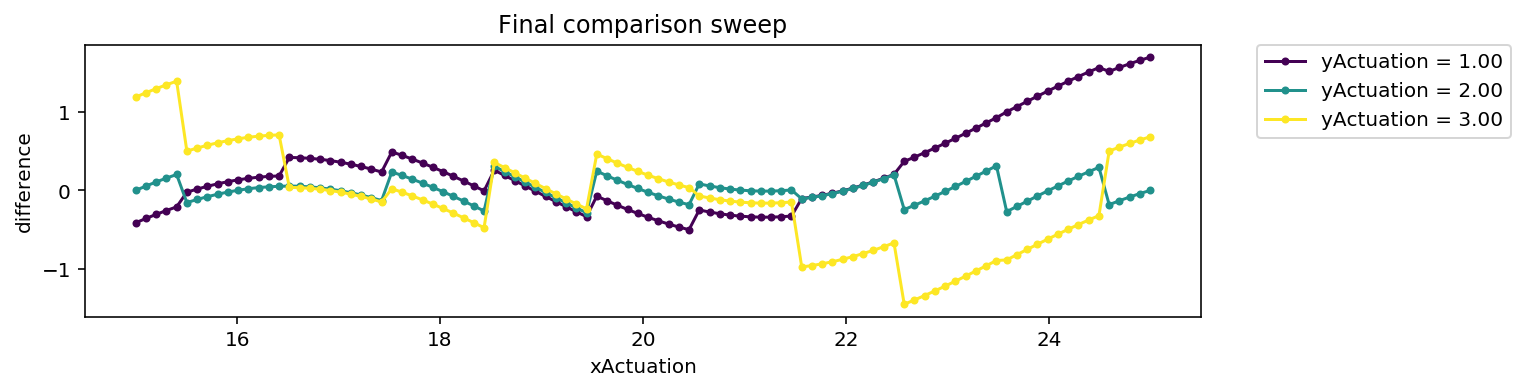

In [11]:
p = Plant()

# First do a 1d sweep
swpA = NdSweeper()
swpA.addMeasurement('measOne', lambda: p.measure()[0])
swpA.addActuation('xActuation', lambda x: p.actuateX(x, rounded=False), np.linspace(15, 25, 100))
swpA.setMonitorOptions(stdoutPrint=False)
swpA.gather()
swpA.plot()
plt.title('Baseline sweep')

# Get its data
baseline = swpA.data['measOne']

# do a 2d sweep where each line is compared to the 1d line
swpB = NdSweeper()
swpB.addMeasurement('measOne', lambda: p.measure()[0])
# The order of these calls matters
swpB.addActuation('xActuation', lambda x: p.actuateX(x, rounded=True), np.linspace(15, 25, 100))
swpB.addStaticData('baseline', baseline) 
swpB.addActuation('yActuation', lambda y: p.actuateY(y), np.linspace(1, 3, 3))
swpB.addParser('difference', lambda d: d['measOne'] - d['baseline'])
swpB.setMonitorOptions(stdoutPrint=False)
swpB.setPlotOptions(xKey='xActuation', yKey='difference')
swpB.gather()
swpB.plot()
_ = plt.title('Final comparison sweep')

## Saving and loading

Saving to file: /Users/tlima/02GitProjects/lightlab/notebooks/Tests/temp-ndsweep.pkl.gz


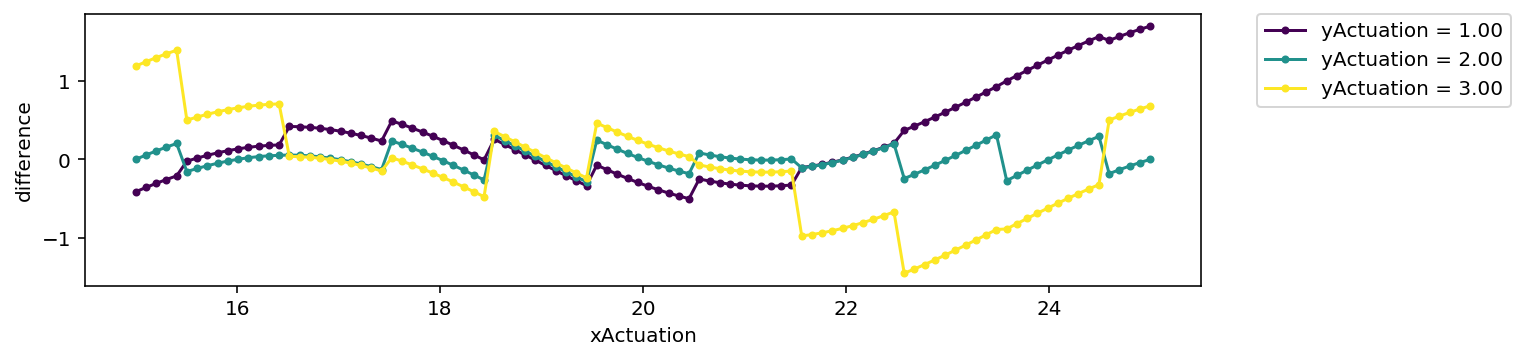

In [12]:
import lightlab.util.io as io
io.fileDir = '.'
fname = 'temp-ndsweep'
swpB.saveObj(fname)

swpC = NdSweeper.loadObj(fname)
swpC.setPlotOptions(xKey='xActuation', yKey='difference')
swpC.plot()

import os
os.remove(fname + '.pkl.gz')